In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from PIL import Image

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = 2

/home/nicholas/anaconda3/envs/cifar10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainset, valset = torch.utils.data.random_split(trainset, [45000, 5000], generator = torch.Generator().manual_seed(515))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

x = next(iter(trainloader))
print(x[1])

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
tensor([6, 2, 2, 4, 4, 0, 8, 4, 4, 1, 7, 7, 0, 5, 6, 4, 0, 4, 4, 3, 5, 6, 6, 9,
        7, 6, 6, 5, 8, 4, 0, 9, 7, 4, 5, 4, 0, 0, 3, 7, 1, 5, 3, 2, 4, 3, 4, 6,
        9, 9, 4, 3, 4, 8, 1, 8, 1, 7, 6, 8, 7, 8, 4, 0, 9, 4, 0, 6, 0, 3, 6, 8,
        2, 0, 4, 9, 8, 5, 9, 0, 4, 8, 2, 6, 4, 5, 7, 2, 7, 4, 7, 0, 9, 7, 0, 6,
        0, 9, 7, 0, 6, 6, 1, 0, 6, 6, 6, 1, 1, 5, 0, 4, 1, 1, 3, 7, 2, 8, 4, 2,
        9, 2, 0, 6, 5, 4, 4, 1, 8, 2, 8, 8, 7, 5, 1, 0, 6, 7, 7, 7, 3, 9, 7, 8,
        9, 2, 4, 4, 8, 0, 2, 3, 6, 4, 9, 1, 6, 4, 2, 3, 4, 1, 7, 2, 6, 1, 1, 0,
        7, 0, 6, 4, 5, 9, 4, 1, 1, 0, 5, 2, 4, 8, 4, 7, 3, 4, 1, 1, 1, 5, 5, 4,
        8, 8, 6, 6, 3, 4, 3, 7, 9, 2, 3, 4, 5, 6, 4, 4, 5, 3, 2, 5, 3, 9, 7, 4,
        7, 5, 2, 0, 7, 7, 5, 2, 5, 9, 0, 7, 7, 8, 4, 3, 6, 9, 7, 7, 6, 2, 5, 1,
        4, 8, 8, 5, 6, 9, 5, 1, 8, 0, 5, 4, 3, 9, 4, 4])


In [3]:
def resnet_model():
    model = torchvision.models.resnet50(pretrained=False, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    return model

In [6]:
class LightningNet(pl.LightningModule):
    def __init__(self, model, lr):
        super().__init__()
        self.model = model
        self.lr = lr
        self.save_hyperparameters()

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        val_loss = F.cross_entropy(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy(preds, y, task='multiclass', num_classes=10)
        self.log("val_loss", val_loss)
        self.log("val_acc", acc)
        return {'val_loss': val_loss}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        test_loss = F.cross_entropy(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy(preds, y, task='multiclass', num_classes=10)
        self.log("test_loss", test_loss)
        self.log("test_acc", acc)
    
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), self.hparams.lr, momentum=0.9)
        return {"optimizer": optimizer}
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        pred = torch.argmax(self.model(x), dim=1)
        return pred

In [20]:
resnet50 = LightningNet(resnet_model(), 0.01)

# train model
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs = 60, callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)])
trainer.fit(model=resnet50, train_dataloaders = trainloader, val_dataloaders = valloader)

/home/nicholas/anaconda3/envs/cifar10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nicholas/anaconda3/envs/cifar10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/nicholas/anaconda3/envs/cifar10/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:263: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HP

Sanity Checking: 0it [00:00, ?it/s]

/home/nicholas/anaconda3/envs/cifar10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/nicholas/anaconda3/envs/cifar10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 59: 100%|██████████| 196/196 [07:18<00:00,  2.24s/it, loss=2.38e-05, v_num=0]

`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 59: 100%|██████████| 196/196 [07:19<00:00,  2.24s/it, loss=2.38e-05, v_num=0]


In [7]:
new_model =  LightningNet.load_from_checkpoint("/home/nicholas/summer_research_2023/basicnn/checkpoint/lightning_logs/version_10/checkpoints/epoch=61-step=10912.ckpt")

# trainer.test(resnet50, testloader)

/home/nicholas/anaconda3/envs/cifar10/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:263: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


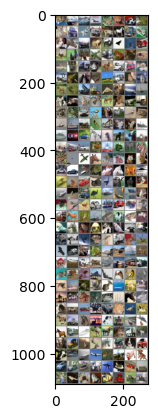

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship


LightningNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [8]:
def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = new_model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

ind = 3

input = images[ind].unsqueeze(0)
input.requires_grad = True

new_model.eval()

tensor([[ 2.7237e-03,  8.8879e-03,  1.0588e-02,  ...,  2.1400e-03,
          7.9754e-04,  1.9628e-04],
        [ 3.7773e-03,  1.4929e-02,  1.5802e-02,  ...,  1.8242e-03,
          1.0050e-03,  3.0846e-04],
        [ 3.0599e-03,  1.1520e-02,  1.3251e-02,  ..., -2.0513e-03,
          1.0949e-03,  6.4938e-04],
        ...,
        [-7.0985e-04, -7.3549e-03, -5.4393e-03,  ..., -2.6424e-04,
         -5.6355e-04, -4.9173e-04],
        [ 2.3633e-04,  7.0276e-05,  1.3251e-03,  ..., -1.7561e-04,
         -8.4594e-04, -3.9770e-04],
        [-7.0985e-04, -1.8968e-03, -7.1909e-04,  ..., -1.3670e-04,
         -4.3392e-04, -2.9198e-04]], dtype=torch.float64,
       grad_fn=<AddBackward0>)
torch.return_types.max(
values=tensor([ 1.1276e-02,  1.5802e-02,  1.5721e-02,  1.4351e-02,  9.8648e-03,
         3.8440e-02,  1.4908e-02,  2.3700e-02,  1.2383e-02,  1.5371e-02,
         1.4132e-02,  2.7018e-02,  2.0317e-02,  1.4915e-02,  1.3593e-02,
         4.3791e-02,  2.5199e-02,  1.6475e-02,  1.7882e-02,  1.905

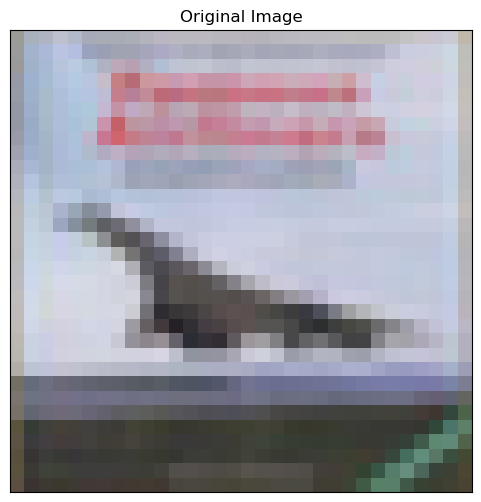

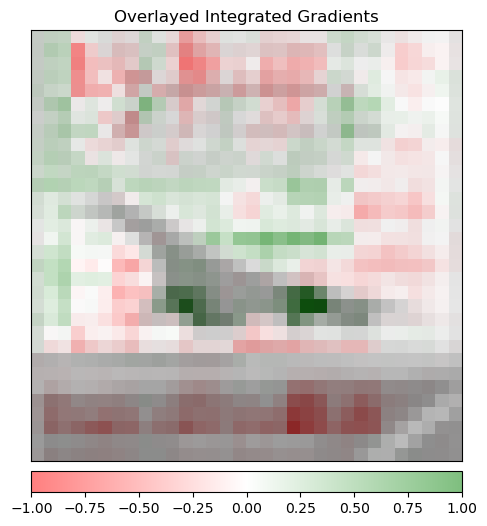

In [16]:
def attribute_image_features(algorithm, input, **kwargs):
    new_model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )

    return tensor_attributions

ig = IntegratedGradients(new_model)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = attr_ig.squeeze()

comb = attr_ig[0] + attr_ig[2] + attr_ig[2]
print(comb)
print(torch.max(comb,1))

attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

x = viz._normalize_attr(attr_ig, 'absolute_value', 2, reduction_axis=2)

print(x.max())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

d = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

In [19]:
print(attr_ig)

[[[ 1.71031237e-04  1.64072378e-03  1.77051480e-03]
  [ 8.79703902e-04  3.54474901e-03  5.61325352e-03]
  [ 1.30031976e-03  3.52265770e-03  6.63396692e-03]
  ...
  [-1.65671339e-03  5.47646515e-04  3.54431404e-03]
  [-1.83701277e-03  2.17056151e-04  1.98071053e-03]
  [-1.88870537e-03 -3.20344392e-05  1.17450375e-03]]

 [[ 3.36197000e-05  1.49620307e-03  2.46186417e-03]
  [ 8.47737217e-04  4.66938496e-03  9.32888771e-03]
  [ 6.96401130e-04  3.78724336e-03  1.07582644e-02]
  ...
  [-4.33026739e-03  1.28511181e-04  6.06251562e-03]
  [-4.37652618e-03 -1.19862004e-03  3.60874482e-03]
  [-3.43020554e-03 -5.39822428e-04  2.24434923e-03]]

 [[ 3.08485191e-04  1.68531276e-03  2.03534333e-03]
  [ 1.04961119e-04  3.78269241e-03  8.83173057e-03]
  [ 9.39331823e-04  3.96911657e-03  9.75704430e-03]
  ...
  [-5.82791431e-03 -1.15035792e-03  4.71318292e-03]
  [-4.81486832e-03 -7.13917953e-04  3.93910947e-03]
  [-3.47202503e-03  2.58207254e-04  2.73935359e-03]]

 ...

 [[-5.72583655e-04 -5.19718419e-04